In [1]:
import pathlib as pl
import matplotlib.pyplot as plt
import matplotlib
from shapely.geometry import Polygon
import flopy
from flopy.discretization import StructuredGrid
from flopy.utils import GridIntersect
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import subprocess
import rasterio
import shapely
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from time import sleep
import shutil
import sys
import time
import subprocess

import warnings
warnings.filterwarnings('ignore')

In [2]:
cwd = os.getcwd()
obs_locs_dir =  pl.Path('../../Locations/Obs_locs').resolve()
print(cwd)
print(obs_locs_dir)

C:\Users\farnut1\Desktop\How-Many-Realizations-main\Refined_Truth_Model\Modflow_Input_Files
C:\Users\farnut1\Desktop\How-Many-Realizations-main\Locations\Obs_locs


In [3]:
# Get model_root_name from listing file
for file in os.listdir(cwd):
    if file.endswith(".dis"):
        disfile = file
model_name = os.path.splitext(disfile)[0]
print("Model Name:", model_name)

sim = flopy.mf6.MFSimulation.load(f'{model_name}', sim_ws=cwd, exe_name='mf6.exe')
sim.set_sim_path(cwd)
model = sim.get_model(f'{model_name}')

Model Name: fp_mf6_model
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package riv...
    loading package ghb...
    loading package wel...
    loading package rch...
    loading package npf...
    loading package oc...
  loading solution package fp_mf6_model...


In [4]:
sim.run_simulation() 

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Groundwater Vistas\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

   MODFLOW 6 compiled Dec 19 2024 21:59:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neithe

(True, [])

In [5]:
fname = (f"{model.name}.hds")
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
maskedhead = np.ma.masked_greater_equal(head, 1e9)
maskedhead = np.ma.masked_less_equal(maskedhead, -1e9)
levels = np.arange(0, 50, 1)

print('head min')
print(maskedhead.min())

print('head max')
print(maskedhead.max())

head min
20.621732495285933
head max
35.06001690197647


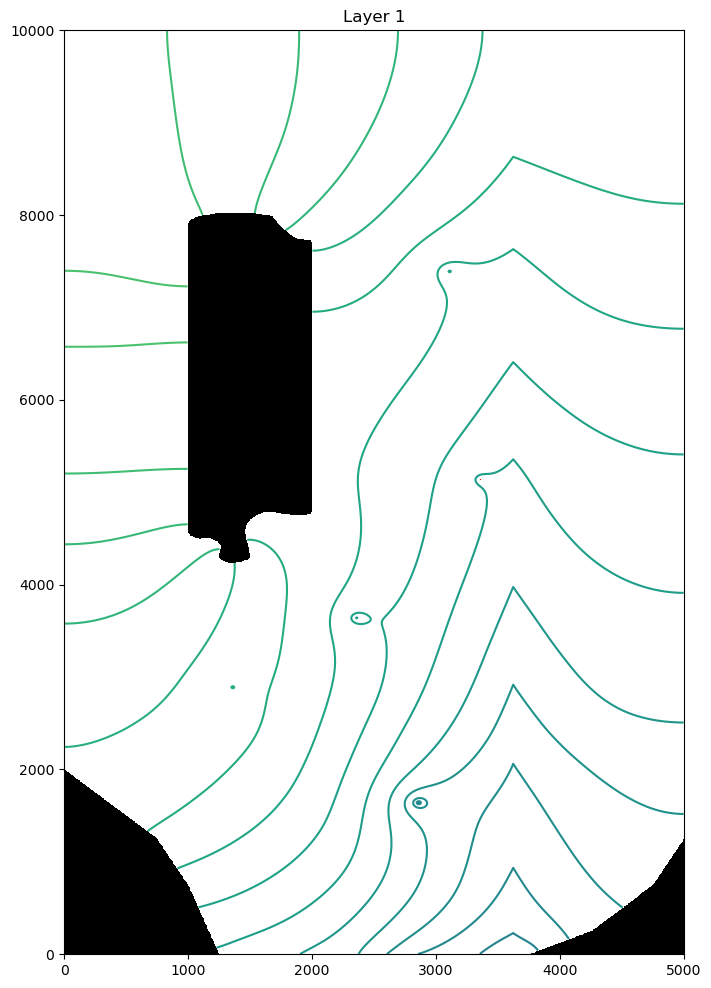

In [6]:
fig, ax = plt.subplots(figsize=(8,12))
ax.set_title('Layer 1')
mapview = flopy.plot.PlotMapView(model, ax=ax)
quadmesh = mapview.plot_ibound()
mapview.plot_bc("WEL")
contour_set = mapview.contour_array(head[0], levels=levels)

### Get new Head values and save to csvs

In [7]:
# Make dataframe of top, botm1, head1
dry_flood_df = pd.DataFrame((model.dis.top.data.reshape(model.modelgrid.ncpl,1)), columns=['top'])
dry_flood_df['botm1'] = model.dis.botm.data[0].reshape(model.modelgrid.ncpl,1)
dry_flood_df['head1'] = head[0].reshape(model.modelgrid.ncpl,1)

# Convert index to node
dry_flood_df.reset_index(inplace=True)
dry_flood_df.rename(columns={'index':'node'}, inplace=True)
dry_flood_df['node'] = dry_flood_df['node']+1

dry_flood_df

,node,top,botm1,head1
0,1,200.0,8.871243,3.424614e+01
1,2,200.0,8.870894,3.424611e+01
2,3,200.0,8.870489,3.424606e+01
3,4,200.0,8.870017,3.424598e+01
4,5,200.0,8.869470,3.424587e+01
...,...,...,...,...
1279995,1279996,200.0,1.106555,1.000000e+30
1279996,1279997,200.0,1.106948,1.000000e+30
1279997,1279998,200.0,1.107288,1.000000e+30
1279998,1279999,200.0,1.107577,1.000000e+30


In [8]:
# Add geometry column
gridcoords = model.modelgrid.geo_dataframe
dry_flood_df = dry_flood_df.join(gridcoords)
dry_flood_df = gpd.GeoDataFrame(dry_flood_df, geometry='geometry')

dry_flood_df

,node,top,botm1,head1,geometry
0,1,200.0,8.871243,3.424614e+01,"POLYGON ((0 10000, 0 9993.75, 6.25 9993.75, 6...."
1,2,200.0,8.870894,3.424611e+01,"POLYGON ((6.25 10000, 6.25 9993.75, 12.5 9993...."
2,3,200.0,8.870489,3.424606e+01,"POLYGON ((12.5 10000, 12.5 9993.75, 18.75 9993..."
3,4,200.0,8.870017,3.424598e+01,"POLYGON ((18.75 10000, 18.75 9993.75, 25 9993...."
4,5,200.0,8.869470,3.424587e+01,"POLYGON ((25 10000, 25 9993.75, 31.25 9993.75,..."
...,...,...,...,...,...
1279995,1279996,200.0,1.106555,1.000000e+30,"POLYGON ((4968.75 6.25, 4968.75 0, 4975 0, 497..."
1279996,1279997,200.0,1.106948,1.000000e+30,"POLYGON ((4975 6.25, 4975 0, 4981.25 0, 4981.2..."
1279997,1279998,200.0,1.107288,1.000000e+30,"POLYGON ((4981.25 6.25, 4981.25 0, 4987.5 0, 4..."
1279998,1279999,200.0,1.107577,1.000000e+30,"POLYGON ((4987.5 6.25, 4987.5 0, 4993.75 0, 49..."


In [ ]:
# dry_flood_df.to_csv('True_heads.csv')
# dry_flood_gdf = gpd.GeoDataFrame(dry_flood_df, geometry=dry_flood_df['geometry'])
# dry_flood_gdf.to_file('True_heads.shp')

In [ ]:
obs_locsR25 =  pd.read_csv(obs_locs_dir / 'R25.csv')
obs_locsR100 = pd.read_csv(obs_locs_dir / 'R100.csv')
obs_locsC25 = pd.read_csv(obs_locs_dir / 'C25.csv')
obs_locsC100 = pd.read_csv(obs_locs_dir / 'C100.csv')

In [ ]:
obs_locsR25 = gpd.GeoDataFrame(obs_locsR25, geometry=gpd.points_from_xy(obs_locsR25['x'], obs_locsR25['y'], crs='EPSG:26915'))
obs_locsR100 = gpd.GeoDataFrame(obs_locsR100, geometry=gpd.points_from_xy(obs_locsR100['x'], obs_locsR100['y'], crs='EPSG:26915'))
obs_locsC25 = gpd.GeoDataFrame(obs_locsC25, geometry=gpd.points_from_xy(obs_locsC25['x'], obs_locsC25['y'], crs='EPSG:26915'))
obs_locsC100 = gpd.GeoDataFrame(obs_locsC100, geometry=gpd.points_from_xy(obs_locsC100['x'], obs_locsC100['y'], crs='EPSG:26915'))

In [ ]:
obs_locsR25_join = gpd.sjoin(obs_locsR25, dry_flood_df, how='left')
obs_locsR100_join = gpd.sjoin(obs_locsR100, dry_flood_df, how='left')
obs_locsC25_join = gpd.sjoin(obs_locsC25, dry_flood_df, how='left')
obs_locsC100_join = gpd.sjoin(obs_locsC100, dry_flood_df, how='left')
obs_locsR25_join

In [ ]:
if 'site_name' not in obs_locsR25_join.columns:
    obs_locsR25_join['site_name'] = [f"o{i}" for i in np.arange(len(obs_locsR25_join)) + 1]
obs_locsR25 = obs_locsR25_join[['site_name','x','y','head1']]
obs_locsR25 = obs_locsR25.rename(columns={'head1':'head'})

if 'site_name' not in obs_locsR100_join.columns:
    obs_locsR100_join['site_name'] = [f"o{i}" for i in np.arange(len(obs_locsR100_join)) + 1]
obs_locsR100 = obs_locsR100_join[['site_name','x','y','head1']]
obs_locsR100 = obs_locsR100.rename(columns={'head1':'head'})

if 'site_name' not in obs_locsC25_join.columns:
    obs_locsC25_join['site_name'] = [f"o{i}" for i in np.arange(len(obs_locsC25_join)) + 1]
obs_locsC25 = obs_locsC25_join[['site_name','x','y','head1']]
obs_locsC25 = obs_locsC25.rename(columns={'head1':'head'})

if 'site_name' not in obs_locsC100_join.columns:
    obs_locsC100_join['site_name'] = [f"o{i}" for i in np.arange(len(obs_locsC100_join)) + 1]
obs_locsC100 = obs_locsC100_join[['site_name','x','y','head1']]
obs_locsC100 = obs_locsC100.rename(columns={'head1':'head'})

In [ ]:
# obs_locsR25.to_csv(obs_locs_dir / 'R25.csv', index=False)
# obs_locsR100.to_csv(obs_locs_dir / 'R100.csv', index=False)
# obs_locsC25.to_csv(obs_locs_dir / 'C25.csv', index=False)
# obs_locsC100.to_csv(obs_locs_dir / 'C100.csv', index=False)

### Add riv obs to truth model

First add a boundname to the stress period data:

In [ ]:
spd = {0: model.riv.stress_period_data.data[0]}
#temporarily recast to dataframe because recarrays are too hard to work with
spd[0] = pd.DataFrame(spd[0])
spd[0]['boundname'] = 'river'
spd[0] = spd[0].to_records(index=False)
spd

Then make a dataframe for the observation input that references the boundname

In [ ]:
riv_obs_df = pd.DataFrame({
    'obsname': ['riv-flux'],
    'type': ['riv'],
    'id': ['river']  # the boundname that we made above; includes all RIV cells
})

In [ ]:
# Turn to recarray
riv_obs_df = riv_obs_df.to_records(index=False)
riv_obs_df

In [ ]:
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    model, save_flows=True, observations={'riv_obs.csv': riv_obs_df}, stress_period_data=spd, boundnames=True,
    filename=f'{model.name}.riv', pname='riv_0')

In [ ]:
sim.write_simulation()
sim.run_simulation() 

### PRT

In [9]:
# Make prt model
prt_root_name = "mf6_prt"
print(prt_root_name)

# Create prt model
prt = flopy.mf6.ModflowPrt(sim, modelname=prt_root_name, model_nam_file=f'{prt_root_name}.nam')

# Create dis from base model
prtdis = flopy.mf6.ModflowGwfdis(prt, length_units=model.modelgrid.units, xorigin=model.modelgrid.xoffset,
                              yorigin=model.modelgrid.yoffset, nlay=model.modelgrid.nlay, nrow=model.modelgrid.nrow,
                              ncol=model.modelgrid.ncol, delc=model.modelgrid.delc, delr=model.modelgrid.delr,
                              top=model.modelgrid.top, botm=model.modelgrid.botm, idomain=model.modelgrid.idomain,
                              pname=prt_root_name+'.dis')

mf6_prt


In [10]:
# Get well locations
wel_loc = []
for i in range(1,len(model.wel.stress_period_data.data[0])):
    wel_loc.append(model.wel.stress_period_data.data[0][i][0])
display(wel_loc)

# Get Well Node Locations
well_nodes = []
for i in range(len(wel_loc)):
    well_nodes.append(model.modelgrid.get_node(wel_loc[i]))
display(well_nodes)

# Assign a different zone number to well cells.
# This makes it easier to determine where particles terminate.

# Make izone and all 0's
izone = np.zeros((model.modelgrid.nlay, model.modelgrid.nrow, model.modelgrid.ncol), dtype=int)
izone = np.ravel(izone)

# Change well nodes to a 1
for i in range(len(well_nodes)):
    node = well_nodes[i]
    izone[node] = 1

# Remake into correct shape
izone = izone.reshape(model.modelgrid.nlay, model.modelgrid.nrow, model.modelgrid.ncol)
izone

[(0, 417, 497), (0, 777, 537), (0, 1017, 377), (0, 1137, 217), (0, 1337, 457)]

[[334097], [622137], [813977], [909817], [1070057]]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 1600, 800))

In [12]:
# Create PRT model input package
mip = flopy.mf6.ModflowPrtmip(prt, pname='mip', porosity=0.1, izone=izone)

# Load Particle starting locs csv
starting_locs = pd.read_csv(os.path.join(cwd,'Starting_Particles_R_Truth.csv'))

# subtract 1 from row and column
starting_locs['row'] -=1
starting_locs['column'] -=1

starting_locs.reset_index(inplace=True)
starting_locs.rename(columns={'index':'pid'}, inplace=True)

# Add o in front of every unique number, turns to string
starting_locs['node'] = 'nn' + starting_locs['node'].astype(str)

# Add layer column
starting_locs['lay'] =0
starting_locs['z'] =1

# Make prt_releasepts tuple
starting_locs['prt_releasepts'] = list(zip(starting_locs['pid'], starting_locs['lay'], starting_locs['row'], starting_locs['column'],
                                           starting_locs['centerX'], starting_locs['centerY'], starting_locs['z'], starting_locs['node']))

# Convert to list
prt_releasepts = starting_locs['prt_releasepts'].tolist()

prp = flopy.mf6.ModflowPrtprp(prt, pname='prp', filename=f'{prt_root_name}.prp', nreleasepts=len(starting_locs),
                              packagedata=prt_releasepts, perioddata={0: ["FIRST"]}, exit_solve_tolerance=1e-5,
                              extend_tracking=True, boundnames=True, istopzone=1, stoptime=9131.25, local_z=True)

In [13]:
# Create output control package
oc = flopy.mf6.ModflowPrtoc(prt, pname='oc',budget_filerecord=[f'{prt_root_name}.bud'],
                            trackcsv_filerecord=[f'{prt_root_name}.trk.csv'], track_release=True, track_terminate=True)

# Flow model interface
exg = flopy.mf6.ModflowGwfprt(sim, exgmnamea=model.name, exgmnameb=prt_root_name, filename=f"{model.name}.gwfprt")

ems = flopy.mf6.ModflowEms(sim, pname='ems', filename=f'{prt_root_name}.ems')
sim.register_solution_package(ems, [prt.name])

In [14]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package fp_mf6_model...
  writing solution package ems...
  writing package fp_mf6_model.gwfprt...
  writing model fp_mf6_model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package riv_0...
    writing package ghb_0...
    writing package wel_0...
    writing package rcha_0...
    writing package npf...
    writing package oc...
  writing model mf6_prt...
    writing model name file...
    writing package mf6_prt.dis...
    writing package mip...
    writing package prp...
    writing package oc...


In [15]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Program Files\Groundwater Vistas\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

   MODFLOW 6 compiled Dec 19 2024 21:59:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neithe

(True, [])

In [16]:
# Load pathline csv file
mf6pl = pd.read_csv(f'{prt_root_name}.trk.csv')
mf6pl

,kper,kstp,imdl,iprp,irpt,ilay,icell,izone,istatus,ireason,trelease,t,x,y,z,name
0,1,1,2,1,1,1,1,0,1,0,0.0,0.0,3.12,9996.88,34.246143,NN1
1,1,1,2,1,2,1,2,0,1,0,0.0,0.0,9.38,9996.88,34.246114,NN2
2,1,1,2,1,3,1,3,0,1,0,0.0,0.0,15.62,9996.88,34.246060,NN3
3,1,1,2,1,4,1,4,0,1,0,0.0,0.0,21.88,9996.88,34.245979,NN4
4,1,1,2,1,5,1,5,0,1,0,0.0,0.0,28.12,9996.88,34.245873,NN5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108231,1,1,2,1,1011173,1,1212721,0,1,0,0.0,0.0,4503.12,528.12,24.022239,NN1212721
1108232,1,1,2,1,1011174,1,1212722,0,1,0,0.0,0.0,4509.38,528.12,24.028535,NN1212722
1108233,1,1,2,1,1011175,1,1212723,0,1,0,0.0,0.0,4515.62,528.12,24.034781,NN1212723
1108234,1,1,2,1,1011176,1,1212724,0,1,0,0.0,0.0,4521.88,528.12,24.040980,NN1212724


In [17]:
# index by particle group and particle ID
mf6pl.set_index(["iprp", "irpt"], drop=False, inplace=True)

# determine which particles ended up in which capture zone
mf6pl["destzone"] = mf6pl[mf6pl.istatus > 1].izone
mf6pl["dest"] = mf6pl.apply(lambda row: ("well" if row.destzone == 1 else pd.NA), axis=1)

mf6pl_in_well_df = mf6pl[mf6pl['dest']=='well']

# Get starting izone = 0 to get the initial cell
mf6pl_in_well_df = mf6pl_in_well_df[mf6pl_in_well_df['izone'] ==0]

# Note, icell is the 1 based node number

mf6pl_in_well_df

kper  kstp  imdl  iprp    irpt  ilay    icell  izone  istatus  \
iprp irpt                                                                    
1    187559     1     1     2     1  187559     1   202739      0        1   
     187560     1     1     2     1  187560     1   202740      0        1   
     187561     1     1     2     1  187561     1   202741      0        1   
     187562     1     1     2     1  187562     1   202742      0        1   
     187563     1     1     2     1  187563     1   202743      0        1   
...           ...   ...   ...   ...     ...   ...      ...    ...      ...   
     936708     1     1     2     1  936708     1  1112425      0        1   
     936709     1     1     2     1  936709     1  1112426      0        1   
     936710     1     1     2     1  936710     1  1112427      0        1   
     936711     1     1     2     1  936711     1  1112428      0        1   
     936712     1     1     2     1  936712     1  1112429      0        1   

             ireason  trelease    t        x        y          z       name  \
iprp irpt                                                                     
1    187559        0       0.0  0.0  2115.62  8415.62  32.172866   NN202739   
     187560        0       0.0  0.0  2121.88  8415.62  32.162663   NN202740   
     187561        0       0.0  0.0  2128.12  8415.62  32.152469   NN202741   
     187562        0       0.0  0.0  2134.38  8415.62  32.142287   NN202742   
     187563        0       0.0  0.0  2140.62  8415.62  32.132115   NN202743   
...              ...       ...  ...      ...      ...        ...        ...   
     936708        0       0.0  0.0  2653.12  1309.38  25.926487  NN1112425   
     936709        0       0.0  0.0  2659.38  1309.38  25.900625  NN1112426   
     936710        0       0.0  0.0  2665.62  1309.38  25.874807  NN1112427   
     936711        0       0.0  0.0  2671.88  1309.38  25.849038  NN1112428   
     936712        0       0.0  0.0  2678.12  1309.38  25.823325  NN1112429   

             destzone  dest  
iprp irpt                    
1    187559       1.0  well  
     187560       1.0  well  
     187561       1.0  well  
     187562       1.0  well  
     187563       1.0  well  
...               ...   ...  
     936708       1.0  well  
     936709       1.0  well  
     936710       1.0  well  
     936711       1.0  well  
     936712       1.0  well  

[95823 rows x 18 columns]

In [18]:
# export to csv
mf6pl_in_well_df.to_csv('True_Capture_Cells.csv')

In [19]:
true_cap_df = pd.read_csv('True_Capture_Cells.csv')
true_cap_df = gpd.GeoDataFrame(true_cap_df, geometry=gpd.points_from_xy(true_cap_df['x'], true_cap_df['y'], crs='EPSG:26915'))
true_cap_df

,iprp,irpt,kper,kstp,imdl,iprp.1,irpt.1,ilay,icell,izone,...,ireason,trelease,t,x,y,z,name,destzone,dest,geometry
0,1,187559,1,1,2,1,187559,1,202739,0,...,0,0.0,0.0,2115.62,8415.62,32.172866,NN202739,1.0,well,POINT (2115.62 8415.62)
1,1,187560,1,1,2,1,187560,1,202740,0,...,0,0.0,0.0,2121.88,8415.62,32.162663,NN202740,1.0,well,POINT (2121.88 8415.62)
2,1,187561,1,1,2,1,187561,1,202741,0,...,0,0.0,0.0,2128.12,8415.62,32.152469,NN202741,1.0,well,POINT (2128.12 8415.62)
3,1,187562,1,1,2,1,187562,1,202742,0,...,0,0.0,0.0,2134.38,8415.62,32.142287,NN202742,1.0,well,POINT (2134.38 8415.62)
4,1,187563,1,1,2,1,187563,1,202743,0,...,0,0.0,0.0,2140.62,8415.62,32.132115,NN202743,1.0,well,POINT (2140.62 8415.62)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95818,1,936708,1,1,2,1,936708,1,1112425,0,...,0,0.0,0.0,2653.12,1309.38,25.926487,NN1112425,1.0,well,POINT (2653.12 1309.38)
95819,1,936709,1,1,2,1,936709,1,1112426,0,...,0,0.0,0.0,2659.38,1309.38,25.900625,NN1112426,1.0,well,POINT (2659.38 1309.38)
95820,1,936710,1,1,2,1,936710,1,1112427,0,...,0,0.0,0.0,2665.62,1309.38,25.874807,NN1112427,1.0,well,POINT (2665.62 1309.38)
95821,1,936711,1,1,2,1,936711,1,1112428,0,...,0,0.0,0.0,2671.88,1309.38,25.849038,NN1112428,1.0,well,POINT (2671.88 1309.38)


In [20]:
true_cap_df = gpd.sjoin(true_cap_df, dry_flood_df, how='right')
true_cap_df = true_cap_df.dropna(subset=['iprp'])
true_cap_df.reset_index(drop=True, inplace=True)
true_cap_df

,index_left,iprp,irpt,kper,kstp,imdl,iprp.1,irpt.1,ilay,icell,...,y,z,name,destzone,dest,node,top,botm1,head1,geometry
0,0.0,1.0,187559.0,1.0,1.0,2.0,1.0,187559.0,1.0,202739.0,...,8415.62,32.172866,NN202739,1.0,well,202739,200.0,6.849082,32.172866,"POLYGON ((2112.5 8418.75, 2112.5 8412.5, 2118...."
1,1.0,1.0,187560.0,1.0,1.0,2.0,1.0,187560.0,1.0,202740.0,...,8415.62,32.162663,NN202740,1.0,well,202740,200.0,6.828069,32.162663,"POLYGON ((2118.75 8418.75, 2118.75 8412.5, 212..."
2,2.0,1.0,187561.0,1.0,1.0,2.0,1.0,187561.0,1.0,202741.0,...,8415.62,32.152469,NN202741,1.0,well,202741,200.0,6.806975,32.152469,"POLYGON ((2125 8418.75, 2125 8412.5, 2131.25 8..."
3,3.0,1.0,187562.0,1.0,1.0,2.0,1.0,187562.0,1.0,202742.0,...,8415.62,32.142287,NN202742,1.0,well,202742,200.0,6.785800,32.142287,"POLYGON ((2131.25 8418.75, 2131.25 8412.5, 213..."
4,4.0,1.0,187563.0,1.0,1.0,2.0,1.0,187563.0,1.0,202743.0,...,8415.62,32.132115,NN202743,1.0,well,202743,200.0,6.764550,32.132115,"POLYGON ((2137.5 8418.75, 2137.5 8412.5, 2143...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95818,95818.0,1.0,936708.0,1.0,1.0,2.0,1.0,936708.0,1.0,1112425.0,...,1309.38,25.926487,NN1112425,1.0,well,1112425,200.0,1.152392,25.926487,"POLYGON ((2650 1312.5, 2650 1306.25, 2656.25 1..."
95819,95819.0,1.0,936709.0,1.0,1.0,2.0,1.0,936709.0,1.0,1112426.0,...,1309.38,25.900625,NN1112426,1.0,well,1112426,200.0,1.132121,25.900625,"POLYGON ((2656.25 1312.5, 2656.25 1306.25, 266..."
95820,95820.0,1.0,936710.0,1.0,1.0,2.0,1.0,936710.0,1.0,1112427.0,...,1309.38,25.874807,NN1112427,1.0,well,1112427,200.0,1.112055,25.874807,"POLYGON ((2662.5 1312.5, 2662.5 1306.25, 2668...."
95821,95821.0,1.0,936711.0,1.0,1.0,2.0,1.0,936711.0,1.0,1112428.0,...,1309.38,25.849038,NN1112428,1.0,well,1112428,200.0,1.092186,25.849038,"POLYGON ((2668.75 1312.5, 2668.75 1306.25, 267..."


In [21]:
true_cap_df.to_file('true_cap.shp')